In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"

In [28]:
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl
def init_graph(in_nodes, out_nodes, f_size, u_hat):
    g = dgl.DGLGraph()
    all_nodes = in_nodes + out_nodes
    g.add_nodes(all_nodes)

    in_indx = list(range(in_nodes))
    out_indx = list(range(in_nodes, in_nodes + out_nodes))
    # add edges use edge broadcasting
    for u in in_indx:
        g.add_edges(u, out_indx)

    # init states
    g.ndata['v'] = th.zeros(all_nodes, f_size)
    g.edata['u_hat'] = u_hat
    g.edata['b'] = th.zeros(in_nodes * out_nodes, 1)
    return g

In [29]:
class DGLRoutingLayer(nn.Module):
    def __init__(self, in_nodes, out_nodes, f_size, u_hat):
        super(DGLRoutingLayer, self).__init__()
        self.g = init_graph(in_nodes, out_nodes, f_size, u_hat)
        self.in_nodes = in_nodes
        self.out_nodes = out_nodes
        self.in_indx = list(range(in_nodes))
        self.out_indx = list(range(in_nodes, in_nodes + out_nodes))

    def forward(self, routing_num=1):
        for r in range(routing_num):
            # step 1 (line 4): normalize over out edges
            in_edges = self.g.edata['b'].view(self.in_nodes, self.out_nodes)
            self.g.edata['c'] = F.softmax(in_edges, dim=1).view(-1, 1)
            def cap_message(edges):
                return {'m': edges.data['c'] * edges.data['u_hat']}
            self.g.register_message_func(cap_message)

            # step 2 (line 5)
            def cap_reduce(nodes):
                return {'s': th.sum(nodes.mailbox['m'], dim=1)}
            self.g.register_reduce_func(cap_reduce)

            # Execute step 1 & 2
            self.g.update_all()

            # step 3 (line 6)
            self.g.nodes[self.out_indx].data['v'] = self.squash(
                self.g.nodes[self.out_indx].data['s'], dim=1)

            # step 4 (line 7)
            v = th.cat([self.g.nodes[self.out_indx].data['v']] * self.in_nodes, dim=0)

            self.g.edata['b'] = self.g.edata['b'] + (
                self.g.edata['u_hat'] * v).sum(
                    dim=1, keepdim=True)

    @staticmethod
    def squash(s, dim=1):
        sq = th.sum(s**2, dim=dim, keepdim=True)
        s_norm = th.sqrt(sq)
        s = (sq / (1.0 + sq)) * (s / s_norm)
        return s

In [30]:
in_nodes = 20
out_nodes = 10
f_size = 4
u_hat=th.randn(in_nodes * out_nodes, f_size)
routing = DGLRoutingLayer(in_nodes, out_nodes, f_size, u_hat)

# routing(10)

In [31]:
entropy_list=[]
dist_list=[]

for i in range(10):
    routing(1)
    dist_matrix = routing.g.edata['c'].view(in_nodes, out_nodes)
    entropy = (-dist_matrix * th.log(dist_matrix)).sum(dim=1)
    entropy_list.append(entropy.data.numpy())
    dist_list.append(dist_matrix.data.numpy())

/data/jinjing/minjie_dgl/dgl/python/dgl/frame.py:183: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  dgl_warning('Initializer is not set. Use zero initializer instead.'


([<matplotlib.axis.XTick at 0x7f19c5adea58>,
 <a list of 10 Text xticklabel objects>)

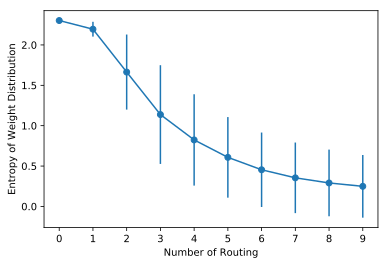

In [32]:
stds = np.std(entropy_list, axis=1)
means = np.mean(entropy_list, axis=1)
plt.errorbar(np.arange(len(entropy_list)), means, stds, marker='o')
plt.ylabel("Entropy of Weight Distribution")
plt.xlabel("Number of Routing")
plt.xticks(np.arange(len(entropy_list)))

In [33]:
import seaborn as sns
import matplotlib.animation as animation

In [38]:
%%capture
fig=plt.figure(dpi=150)
fig.clf()
ax=fig.subplots()
def dist_animate(i):
    ax.cla()
    sns.distplot(dist_list[i].reshape(-1), kde=False, ax=ax)
    ax.set_xlabel("Weight Distribution Histogram")
    ax.set_title("Routing: %d" % (i))
ani = animation.FuncAnimation(fig, dist_animate, frames=len(entropy_list), interval=500)
# ani.save("./capsule_dist.gif",writer='imagemagick')

In [39]:
ani

/home/jinjing/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [18]:
import networkx as nx
from networkx.algorithms import bipartite
g=routing.g.to_networkx()

/data/jinjing/minjie_dgl/dgl/python/dgl/graph.py:513: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


In [40]:
%%capture
X, Y = bipartite.sets(g)
height_in=10
height_out=height_in*0.8
height_in_y=np.linspace(0,height_in,in_nodes)
height_out_y=np.linspace((height_in-height_out)/2,height_out,out_nodes)
pos = dict()

fig2=plt.figure(figsize=(8,3),dpi=150)
fig2.clf()
ax=fig2.subplots()
pos.update( (n, ( i,1)) for i, n in zip(height_in_y, X) ) # put nodes from X at x=1
pos.update( (n, ( i,2)) for i, n in zip(height_out_y, Y) ) # put nodes from Y at x=2
def weight_animate(i):
    ax.cla()
    ax.axis('off')
    ax.set_title("Routing: %d  " % i)
    dm=dist_list[i]
    nx.draw_networkx_nodes(g, pos, nodelist=range(in_nodes), node_color='r', node_size=100, ax=ax)
    nx.draw_networkx_nodes(g, pos, nodelist=range(in_nodes,in_nodes+out_nodes), node_color='b', node_size=100, ax=ax)
    for edge in g.edges():
        nx.draw_networkx_edges(g,pos,edgelist=[edge],width=dm[edge[0],edge[1]-in_nodes]*1.5, ax=ax)
ani2 = animation.FuncAnimation(fig2, weight_animate, frames=len(dist_list), interval=500)
# ani2.save("./capsule_viz.gif",writer='imagemagick')

In [41]:
ani2